#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Необходимо:

1. Загрузить данные и выполнить их ресемплирование.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [ ]:
# подключение библиотек
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

# !pip install -q catboost
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# загрузка данных
try:
    data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Прогнозирование заказов такси/taxi.csv')
except:
    data = pd.read_csv('/datasets/taxi.csv')

In [ ]:
# установим в качестве индекса дату и отсортируем их по очередности
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime')
data = data.sort_index(ascending=True)

In [ ]:
# выполним ресеймплирование к 1 часу
data = data.resample('1H').sum()

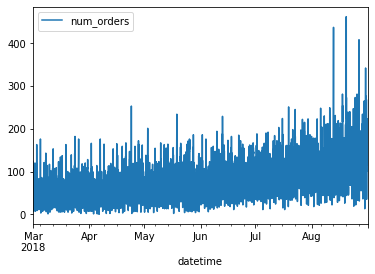

In [ ]:
data.plot();

**Вывод:** произвели загрузку данных. Колонку даты перевели в индексы и отсортировали по возрастанию. Провели рейсемплинорование к 1 часу.

## Анализ

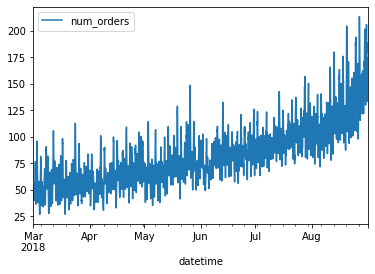

In [ ]:
data.rolling(10).mean().plot();

Произведем декомпозицию данных, выделим тренд, сезоннасть и шумы.

In [ ]:
decomposed = seasonal_decompose(data)

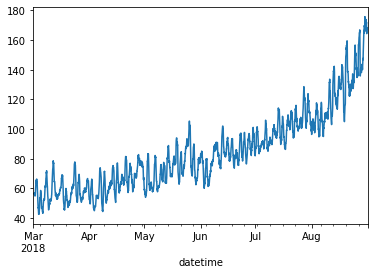

In [ ]:
decomposed.trend.plot();

Тренд по нашим данным на увеличение от месяца к месяцу.

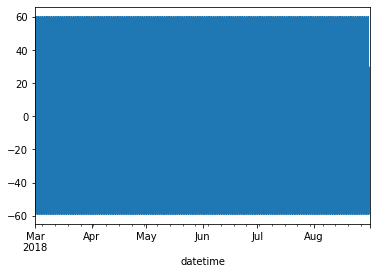

In [ ]:
decomposed.seasonal.plot();

В текущем виде сезонность тяжело рассмотреть, увеличим период.

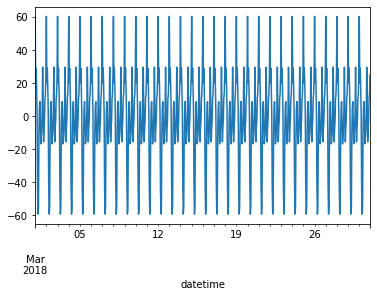

In [ ]:
decomposed.seasonal['2018-03-01': '2018-03-30'].plot();

Еще увеличим.

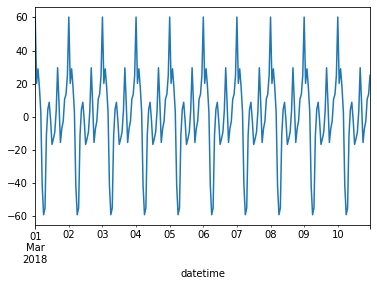

In [ ]:
decomposed.seasonal['2018-03-01': '2018-03-10'].plot();

Поведение сезонной составляющей не зависит от дня недели.

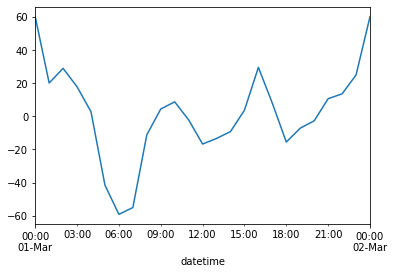

In [ ]:
decomposed.seasonal['2018-03-01 00:00': '2018-03-02 00:00'].plot();

Видно как спрос на такси меняется в течении дня. После работы (18.00) и до 12 часов ночи спрос растет с быстрым темпом. Далее падает до 6 утра. После чего постепенно происходит рост.

Ну и оставшиеся шумы.

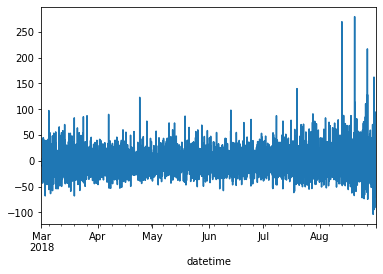

In [ ]:
decomposed.resid.plot();

Видно что шумы увеличиваются в августе.

Произведем ресемплирование по дню, для уточнения сезонной составляющей.

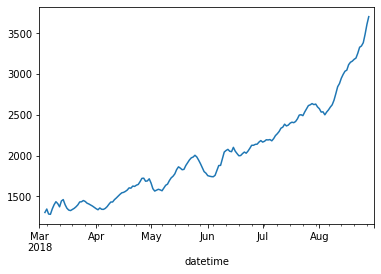

In [ ]:
data_1 = data.resample('1D').sum()
decomposed_1 = seasonal_decompose(data_1)
decomposed_1.trend.plot();

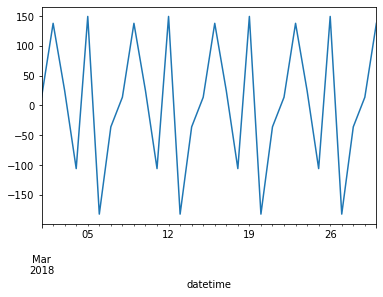

In [ ]:
decomposed_1.seasonal['2018-03-01': '2018-03-30'].plot();

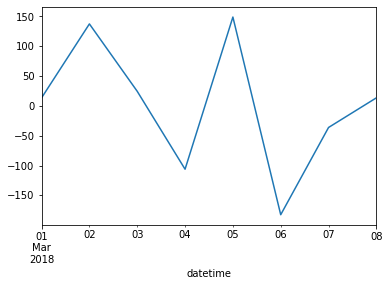

In [ ]:
decomposed_1.seasonal['2018-03-01': '2018-03-08'].plot();

При ресемплированию ко дню, мы видим сезонность по дням недели. К концу недели количество вызовов возростает, наблюдается снижение только в воскресенье и во вторник.

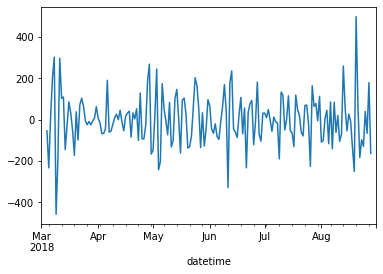

In [ ]:
decomposed_1.resid.plot();

Попробуем получить стационарный показатель по количеству заказов такси путем введения разности временного ряда.

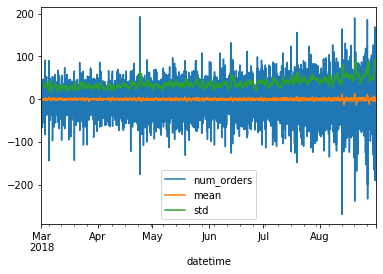

In [ ]:
data_difference = data - data.shift()
data_difference['mean'] = data_difference['num_orders'].rolling(24).mean()
data_difference['std'] = data_difference['num_orders'].rolling(24).std()
data_difference.plot();

**Вывод:** Произвели загрузку данных. Декомпозировали наши данные. Выделили возростающий тренд, сезонность в течении одного дня, не зависимо от дня недели. Отметили увеличение шумов в августе. При введении разности по времени удалось получить стационарный показатель по среднему скользящему, это говорит о возможности построения прогноза.




## Обучение

Сформируем функцию которая наполняет наши данные признаками: день недели, час. А также вычисляет скользящую среднюю.

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Ранее мы выявили сезонность: час дня и день недели. То в качестве признаков мы их как раз и задаем. А также добавляем скользящую среднюю, с окном 24 часа (исходя из сезонности). Проведем разделение на обучающую и тестовую выборки. Разделим выборки на признаки и целевые показатели.

In [ ]:
make_features(data, 0, 24)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

target = train['num_orders']
features = train.drop(['num_orders'], axis=1)

target_test = test['num_orders']
features_test = test.drop(['num_orders'], axis=1)

Модель Линейной регрессии.

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
lr = GridSearchCV(estimator=LinearRegression(), cv=tscv, scoring = 'neg_root_mean_squared_error', param_grid={})
lr.fit(features, target)
print('Показатель RMSE:', (-1) * lr.best_score_)

Показатель RMSE: 35.4770285548951


In [ ]:
# сформируем массив, где будем сохранять полученные результаты
table = []
table.append(['LinearRegression', (-1) * lr.best_score_])

Модель Дерево решений

In [ ]:
# введем значение random state
RANDOM_STATE = 55555

In [ ]:
dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)

parameters = {'max_depth': [1, 11],
        'min_samples_split': [2, 11],
        'min_samples_leaf': [1, 11]}

grid_dtr = GridSearchCV(estimator=dtr, cv=tscv, scoring = 'neg_root_mean_squared_error', param_grid=parameters)
grid_dtr.fit(features, target)
rmse_dtr = round(grid_dtr.best_score_ * (-1), 3)
print('Показатель RMSE:', rmse_dtr)

Показатель RMSE: 26.176


In [ ]:
table.append(['DecisionTreeRegressor', rmse_dtr])

Модель случайный лес

In [ ]:
rfr = RandomForestRegressor(random_state=RANDOM_STATE)

parameters = {'max_depth': [1, 11],
        'n_estimators': [20, 100],
        'min_samples_leaf': [1, 11]}

grid_rfr = GridSearchCV(estimator=rfr, cv=tscv, scoring = 'neg_root_mean_squared_error', param_grid=parameters)
grid_rfr.fit(features, target)
rmse_rfr = round(grid_rfr.best_score_ * (-1), 3)
print('Показатель RMSE:', rmse_rfr)

Показатель RMSE: 25.387


In [ ]:
table.append(['RandomForestRegressor', rmse_rfr])

LightGBM модель

In [ ]:
lgbm = LGBMRegressor(metric=['rmse'], verbose=-1, seed=RANDOM_STATE, force_col_wise=True)

parameters = {'max_depth': [1, 11],
        'num_iterations': [20, 100],
        'min_samples_leaf': [1, 11]}

grid_lgbm = GridSearchCV(estimator=lgbm, cv=tscv, scoring = 'neg_root_mean_squared_error', param_grid=parameters)
grid_lgbm.fit(features, target)
rmse_lgbm = round(grid_lgbm.best_score_ * (-1), 3)
print('Показатель RMSE:', rmse_lgbm)

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[Light

In [ ]:
table.append(['LGBMRegressor', rmse_lgbm])

CatBoost модель

In [ ]:
cbr = CatBoostRegressor(loss_function='RMSE', verbose=0, random_seed=RANDOM_STATE)

parameters = {'iterations': [100, 300, 500],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8]}

grid_cbr = GridSearchCV(estimator=cbr, cv=tscv, scoring = 'neg_root_mean_squared_error', param_grid=parameters)
grid_cbr.fit(features, target)
rmse_cbr = round(grid_cbr.best_score_*(-1), 3)
print('Показатель RMSE:', rmse_cbr)

Показатель RMSE: 24.689


In [ ]:
table.append(['CatBoostRegressor', rmse_cbr])

Произведем выбор лучшей модели по показателю RMSE полученных на обучающей выборке.

In [ ]:
d = pd.DataFrame(table, columns=['Model','RMSE'])
d.pivot_table(index='Model')

,RMSE
Model,
CatBoostRegressor,24.689000
DecisionTreeRegressor,26.176000
LGBMRegressor,24.910000
LinearRegression,35.477029
RandomForestRegressor,25.387000


**Вывод:** произвели наполнение признаками наши данные, разделили на выборки и выделили обучающие признаки и целевой. Произвели подбор гиперпараметров для получения лучших моделей по метрике RMSE. Обучение и предсказания произвели на нескольких регрессионных моделях.

**Лучшая модель CatBoostRegressor с RMSE 24.689. Ее и будем использовать на тестовых данных для получения прогноза.**

## Тестирование

Получим прогнозные предсказания для тестовой выборки и вычислим метрику RMSE.

In [ ]:
pred_test = grid_cbr.best_estimator_.predict(features_test)
rmse_cb = round((mean_squared_error(target_test, pred_test))**0.5, 3)
print(rmse_cb)

42.241


Построим график сравнения целевого признака и прогнозного.

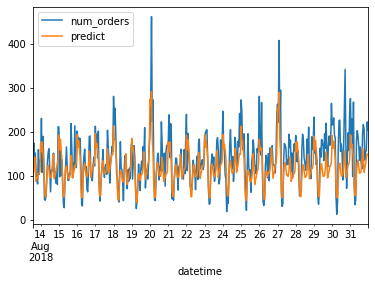

In [ ]:
data_plot = pd.DataFrame(target_test)
data_plot['predict'] = pred_test
data_plot.plot();

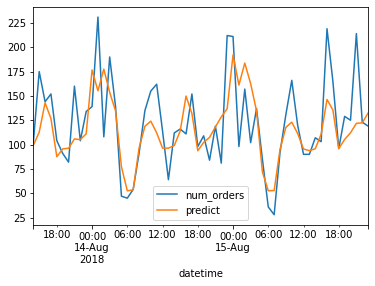

In [ ]:
data_plot['2018-08-13':'2018-08-15'].plot();

Сравним полученные результаты с константной моделью. В качестве простой модели во Временных Рядах используют заполнение предыдущим значением.

In [ ]:
pred_dr = target_test.shift()
pred_dr[0] = target[-1]
rmse_dr = round((mean_squared_error(target_test, pred_dr))**0.5, 3)
print(rmse_dr)

58.856


**Вывод:** Модель CatBoost на тестовой выборке получила RMSE 42.241 (что удовлетворяет условиям проекта). Для сравнения у простой модели показатель выше - 58.856.

Оснавная причина отличий в худшую сторону показателя RMSE на тестовых данных по сравнению с обучающими - увеличение шума на последнем месяце, то есть как раз на тестовых данных.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48